In [149]:
import pyvisa
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import sys
import serial
import tqdm
from scipy.optimize import curve_fit
import pandas as pd
from IPython.display import clear_output

In [ ]:
# Oscilloscope IP Address
OSCILLOSCOPE_IP = "35.15.225.124"  # Change if needed

# Connect to oscilloscope
rm = pyvisa.ResourceManager('@py')
oscilloscope = rm.open_resource(f"TCPIP::{OSCILLOSCOPE_IP}::INSTR")

# Set communication parameters
oscilloscope.timeout = 5000  # 5 seconds
oscilloscope.write_termination = '\n'
oscilloscope.read_termination = '\n'

# Get waveform parameters
ymult = float(oscilloscope.query("WFMPRE:YMULT?"))
yoff = float(oscilloscope.query("WFMPRE:YOFF?"))
yzero = float(oscilloscope.query("WFMPRE:YZERO?"))
xzero = float(oscilloscope.query("WFMPRE:XZERO?"))
time_scale = float(oscilloscope.query("HORizontal:SCAle?"))
t_offset = int(-1 * float(oscilloscope.query("WFMPRE:xzero?")) / float(oscilloscope.query("WFMPRE:XINCR?")))

oscilloscope.write("DATa:STOP 10000")
oscilloscope.write("ACQuire:NUMAVg 512") # max averaging

print(f"Oscilloscope configured for data acquisition")

Oscilloscope configured for data acquisition


In [151]:
class PrologixGPIB(object):
	def __init__(self, devpath):
		self.gpib = serial.Serial(devpath, baudrate=115200)
		self.gpib.timeout = 1

		# Query version to make sure it is live
		self.gpib.write(b'++ver\n')
		resp = self.gpib.readline()
		if not resp.startswith(b'Prologix'):
			raise RuntimeError('Cannot communicate with GPIB adapter at ' + devpath)

		self('mode 1')

	def __call__(self, command, response=False, device=15):
		if device is not None:
			self.gpib.write(('++addr %d\n' % device).encode('us-ascii'))
		self.gpib.write((command + '\n').encode('us-ascii'))
		if response:
			out = self.gpib.readline().decode('us-ascii')
			if len(out) == 0:
				raise TimeoutError('Timeout on command %s' % command)
			return out.strip()

	def auto_rw(self, val=None):
		if val is True:
			self('++auto 1')
		elif val is False:
			self('++auto 0')
		else:
			return (self('++auto', True) == '1')

	def addr(self, addr):
		self('++addr %d' % addr)

try:
    gpib = PrologixGPIB('COM3')
except:
    pass

- Power Supply : device 5
- Pulse Generator : device 15

In [152]:
# set up power supply
gpib('output:state 1', response=False, device=5)

def set_current(current):
    #gpib('output:state 0', response=False, device=5)
    gpib(f'current {current}', response=False, device=5)
    gpib('voltage max', response=False, device=5)
    gpib('output:state 1', response=False, device=5)

In [153]:
time_const = 0.000060000000/180

gpib(f'DLAY 3,2,{time_const*180}') # first pulse 180 degrees
gpib(f'DLAY 5,4,{time_const*90}') # second pulse 90 degrees

def pulse_delay(delay_time):
    gpib(f'DLAY 4,3,{delay_time*1e-3}') # delay between pulses in milliseconds

#pulse_delay(1.6)

In [ ]:
def read_scope(data_wait):
    # restart acquisition
    oscilloscope.write("ACQuire:STATE 0")
    oscilloscope.write("ACQuire:STATE 1")
    # Read data from oscilloscope
    time.sleep(data_wait)
    oscilloscope.write("CURVE?")
    data = oscilloscope.read_raw()
    data = np.frombuffer(data, dtype=np.int8)
    data = yzero + ymult * (data - 128)
    return data

In [155]:
def extract_amplitude(data, delay, t_offset, window, avg_roll):
        delay_time = int(2000*delay)
        
        # rolling average to remove noise
        data = np.convolve(data, np.ones(avg_roll)/avg_roll, mode='same')
        
        cropped_data = data[t_offset+delay_time:] * 1000 # convert to mV
        cropped_data = cropped_data[:window]
        cropped_data = cropped_data - np.mean(cropped_data) # remove DC offset
        
        plt.plot(cropped_data, label=f"{delay:.4f} ms", alpha=0.5)
        amplitude = np.max(cropped_data) - np.min(cropped_data)
        return amplitude 

In [156]:
def func(x, a, b, c):
    x = np.array(x)
    return a * np.exp(b * x) + c

In [160]:
# TUNE MAGNETIC FIELD FOR MAX AMPLITUDE
measuring_time = 0.3 # seconds, max 10
avg_roll = 50; window = 500
min_current = 6.1; max_current = 6.3
current_step = 0.001

# CONSTANT PULSES FOR OPTIMIZATION
pulses = [90, 180] # degrees
delay_time = 2 # ms
gpib(f'DLAY 3,2,{time_const*pulses[0]}')
gpib(f'DLAY 5,4,{time_const*pulses[1]}')
pulse_delay(delay_time)

currents = []
amplitudes = []

pulse_delay(delay_time)
for current in tqdm.tqdm(np.arange(min_current, max_current, current_step)):
    set_current(current)    
    data = read_scope(measuring_time)
    amplitude = extract_amplitude(data, delay_time, t_offset, window, avg_roll)
    amplitudes.append(amplitude)
    currents.append(current)
    
    clear_output(wait=True)
    plt.clf()
    plt.scatter(currents, amplitudes, color='red', s=10)
    plt.xlabel("Current (A)")
    plt.ylabel("Amplitude (mV)")
    plt.title("Amplitude vs Current")
    plt.show()
    
    # if optimization is complete, break
    # if len(currents) > 20 and amplitudes[-1] < np.max(amplitudes) * 0.5:
    #     break

print("Optimization complete.")
print("Best current:", currents[np.argmax(amplitudes)], "A")
print("Best amplitude:", np.max(amplitudes), "mV")

set_current(currents[np.argmax(amplitudes)]) # Set to best current

 30%|███       | 61/201 [01:15<02:53,  1.24s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Amplitude (mV)')

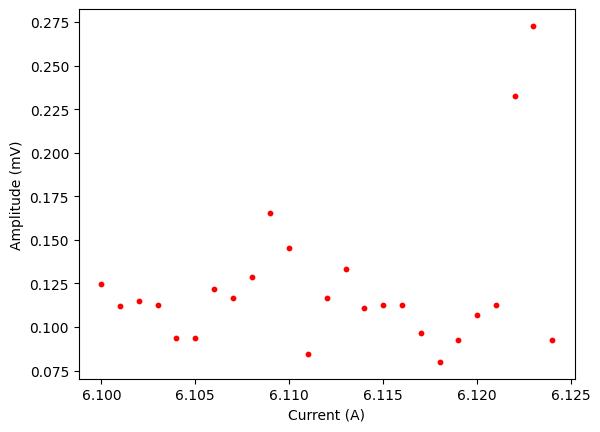

In [158]:
plt.scatter(currents, amplitudes, color='red', s=10)
plt.xlabel("Current (A)")
plt.ylabel("Amplitude (mV)")

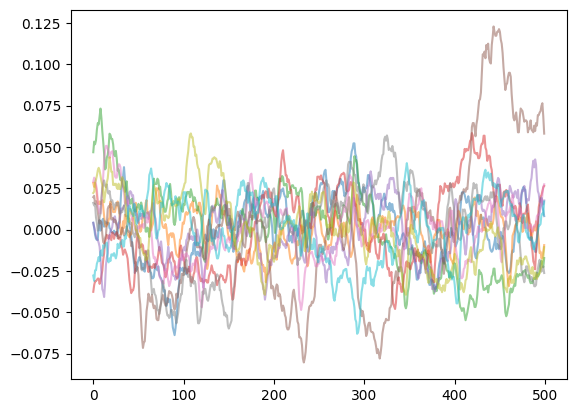

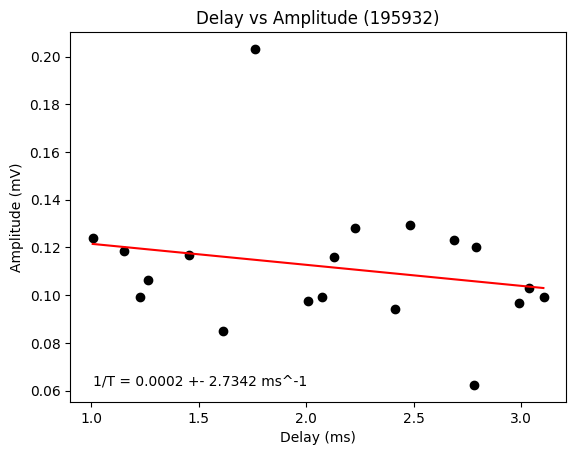

Pulses:   4%|▍         | 21/500 [00:12<04:46,  1.67it/s]


KeyboardInterrupt: 

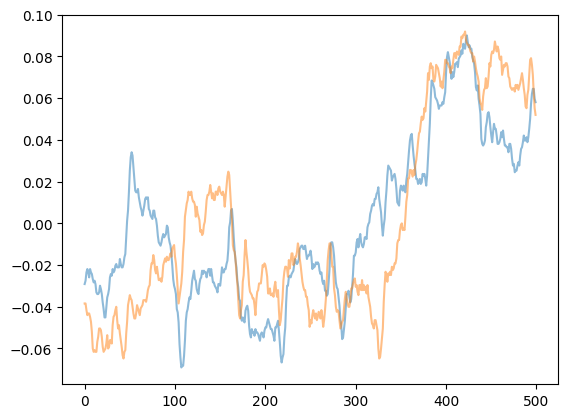

In [159]:
measuring_time = 0.3 # seconds, max 10
avg_roll = 50; window = 500
pulses = [180, 90] # degrees
min_time = 1; max_time = 3.5
graph_update = 10

amplitudes = []
delays = []
start_time_string = time.strftime("%H%M%S")
gpib(f'DLAY 3,2,{time_const*pulses[0]}')
gpib(f'DLAY 5,4,{time_const*pulses[1]}')

for i in tqdm.trange(500, desc="Pulses"):
    if (i+1) % graph_update == 0:
        clear_output(wait=True)
        plt.show() # displays raw data traces for last graph_update pulses
        
        plt.plot(delays, amplitudes, 'ko')
        plt.xlabel("Delay (ms)")
        plt.ylabel("Amplitude (mV)")
        plt.title(f"Delay vs Amplitude ({start_time_string})")
        #plt.ylim(0,0.4)
        try:
            popt, pcov = curve_fit(func, delays, amplitudes, p0=[0.5, -1, 0], maxfev=10000)
            plt.plot(np.arange(min(delays), max(delays), 0.001), func(np.arange(min(delays), max(delays), 0.001), *popt), 'r-')
            plt.text(min(delays), min(amplitudes), f"1/T = {(-1*popt[1]):.4f} +- {abs(np.sqrt(np.diag(pcov))[1]):.4f} ms^-1")
        except KeyboardInterrupt:
            break
        except Exception as e:
            print(f"Curve fitting error: {e}")
        plt.show()
        plt.pause(0.001)
        plt.clf()
        
    delay = round(np.random.uniform(min_time, max_time), 3)
    #delay = np.arange(min_time, max_time, 0.001)[i]
    pulse_delay(delay)
    data = read_scope(measuring_time)
    amplitude = extract_amplitude(data, delay, t_offset, window, avg_roll)
    
    amplitudes.append(amplitude)
    delays.append(delay)

In [ ]:
# Save data to CSV
df = pd.DataFrame({'delay': delays, 'amplitude': amplitudes})
df.to_csv(f'data/{start_time_string}-M{measuring_time}-{pulses[0]}t{pulses[1]}-{avg_roll}-{t_offset}-{window}.csv', index=False)

In [ ]:
"""
NOTES ON WAVEFORM ACQUIRED
initial 90deg pulse starts at 1740, 300 samples long
1740:2040

timing for echo happens ~2*delay after the pulse
1400+2000*delay
1000 sample long for 1ms capture window
"""

'\nNOTES ON WAVEFORM ACQUIRED\ninitial 90deg pulse starts at 1740, 300 samples long\n1740:2040\n\ntiming for echo happens ~2*delay after the pulse\n1400+2000*delay\n1000 sample long for 1ms capture window\n'

In [ ]:
# close connection
oscilloscope.close()
rm.close()
print(f"Connection closed")

Connection closed


(0.0, 0.4)

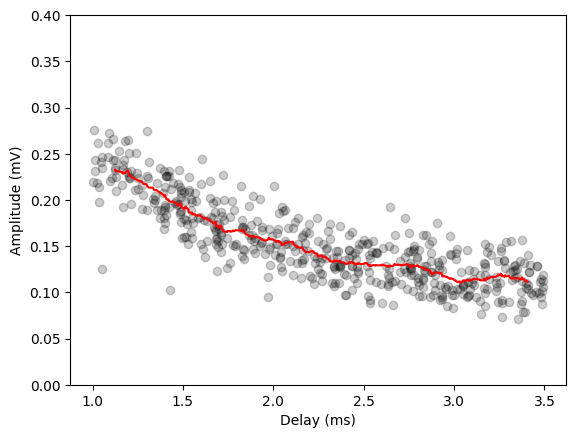

In [ ]:
df = pd.read_csv(f'data/{start_time_string}-M{measuring_time}-{pulses[0]}t{pulses[1]}-{avg_roll}-{t_offset}-{window}.csv')

# sort data by delay
df = df.sort_values(by='delay')

# plot data
plt.plot(df['delay'], df['amplitude'], 'ko', alpha=0.2)
plt.xlabel("Delay (ms)")
plt.ylabel("Amplitude (mV)")

# rolling average to remove noise
df['amplitude'] = df['amplitude'].rolling(window=40, center=True).mean()

plt.plot(df['delay'], df['amplitude'], 'r-')
plt.ylim(0,0.4)

100%|██████████| 7/7 [00:00<00:00, 80.00it/s]


100 mM: 1/T = 0.5098 +- 0.0953 ms^-1
200 mM: 1/T = 0.5016 +- 0.0495 ms^-1
300 mM: 1/T = 0.6522 +- 0.0725 ms^-1
400 mM: 1/T = 0.8220 +- 0.0611 ms^-1
500 mM: 1/T = 0.9858 +- 0.0748 ms^-1
600 mM: 1/T = 1.2310 +- 0.0639 ms^-1
700 mM: 1/T = 1.3602 +- 0.0838 ms^-1


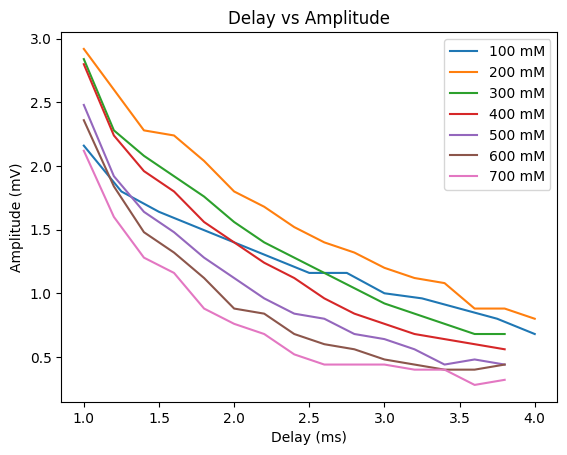

In [ ]:
concentrations = {
    100 : ['105351-10.csv'],
    200 : ['110245-10.csv'],
    300 : ['110713-10.csv'],
    400 : ['111035-10.csv'],
    500 : ['111343-10.csv'],
    600 : ['111654-10.csv'],
    700 : ['111953-10.csv']
    }


concs = []
t2 = []
t2_err = []
for conc, files in tqdm.tqdm(concentrations.items()):
    for file in files:
        df = pd.read_csv(f'data/{file}')
        plt.plot(df['delay'], df['amplitude'], label=f"{conc} mM")
        
        # fit to exponential decay
        popt, pcov = curve_fit(func, df['delay'], df['amplitude'], p0=[0.5, -1, 0], maxfev=10000)
        
        print(f"{conc} mM: 1/T = {(-1*popt[1]):.4f} +- {abs(np.sqrt(np.diag(pcov))[1]):.4f} ms^-1")
        concs.append(conc); t2.append(-1*popt[1]); t2_err.append(abs(np.sqrt(np.diag(pcov))[1]))
        
plt.legend()
plt.xlabel("Delay (ms)")
plt.ylabel("Amplitude (mV)")
plt.title("Delay vs Amplitude")
#plt.show()

# export data
df = pd.DataFrame({'concentration': concs, 'T2': t2, 'T2_err': t2_err})
df.to_csv(f'data/T2.csv', index=False)